# Multi-Stage Training

This notebook shows how to train a neural network to predict secondary
structures using different 

In [1]:
import numpy as np
from diurnal import database, structure, train, evaluate, transform, visualize
from diurnal.models import deep
from diurnal.models.deep import cnn
from torch import optim, nn

In [2]:
database.download("./data/", "archiveII")
SRC = "./data/archiveII/"  # Input directory containing the CT files.
SIZE = 128  # RNA molecule maximum length (longer ones are filtered out).
DST = f"./data/archiveII_processed_{SIZE}/"  # Output directory of the formatted files.
names = database.format_filenames(SRC, DST + "names.txt", SIZE)
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

2024-06-02T15:29:41.320400 > INFO Download and install an RNA database.
2024-06-02T15:29:41.350065 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.
2024-06-02T15:29:41.351234 > INFO Extract the filenames from the directory `./data/archiveII/`.


100%|██████████| 3975/3975 [00:00<00:00, 12039.57it/s]


2024-06-02T15:29:41.740751 >     Detected 3975 files. Kept 2326 files.
2024-06-02T15:29:41.744394 >     The file `./data/archiveII_processed_128/names.txt` already contains the names.


In [3]:
def format(dst: str, names: list[str]):
    # Primary structures
    pp_half_scalar = lambda x, y: transform.halve_matrix(
        structure.Primary.to_matrix(
            x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
        )
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_half_scalar.npy",
        SIZE, pp_half_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", SIZE, structure.Primary.to_mask
    )
    # Secondary structures.
    half_distance_formatter = lambda x, y: transform.halve_matrix(
        structure.Secondary.to_distance_matrix(x, y, power=5)
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance_half.npy",
        SIZE, half_distance_formatter
    )
    half_distance_formatter = lambda x, y: transform.halve_matrix(
        structure.Secondary.to_distance_matrix(x, y, power=2)
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance_half_2.npy",
        SIZE, half_distance_formatter
    )
    half_contact = lambda x, y: transform.halve_matrix(
        structure.Secondary.to_matrix(x, y)
    )
    database.format_secondary_structure(
        names, f"{dst}contact_half.npy", SIZE, half_contact
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", SIZE,
        structure.Secondary.to_matrix
    )

In [4]:
format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-06-02T15:29:41.763707 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_half_scalar.npy`.
2024-06-02T15:29:41.772114 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_half_scalar.npy` already contains the formatted data.
2024-06-02T15:29:41.772114 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_masks.npy`.
2024-06-02T15:29:41.807027 >     The file `./data/archiveII_processed_128/validation/primary_masks.npy` already contains the formatted data.
2024-06-02T15:29:41.810655 > INFO Formatting secondary structures into `./data/archiveII_processed_128/validation/secondary_distance_half.npy`.
2024-06-02T15:29:41.907018 >     The file `./data/archiveII_processed_128/validation/secondary_distance_half.npy` already contains the formatted data.
2024-06-02T15:29:41.915543 > INFO Formatting secondary structures into `./data/archiveII_processed_128/valida

In [14]:
def format_data(input, output) -> tuple:
    train_set = {
        "input": (np.load(f"{DST}train/{input}.npy"), ),
        "output": np.load(f"{DST}train/{output}.npy"),
        "names": []
    }
    validation_set = {
        "input": (np.load(f"{DST}validation/{input}.npy"), ),
        "output": np.load(f"{DST}validation/{output}.npy"),
        "names": []
    }
    test_set = {
        "input": (np.load(f"{DST}test/{input}.npy"), ),
        "output": np.load(f"{DST}test/{output}.npy"),
        "target": np.load(f"{DST}test/secondary_contact.npy"),
        "mask": np.load(f"{DST}test/primary_masks.npy"),
        "names": []
    }
    return train_set, validation_set, test_set


def evaluate_model(model, data) -> list[float]:
    f1 = []
    for i in range(len(data["output"])):
        p = model.predict([data["input"][0][i]])
        p *= data["mask"][i]
        p = transform.quantize(p, True)
        t = data["target"][i]
        f1.append(evaluate.ContactMatrix.f1(t, p))
    return f1


def check(model, data, index):
    p = model.predict([data["input"][0][index]])
    t = data["target"][index]
    visualize.compare_pairings(t, transform.quantize(p * data["mask"][index], True))


In [ ]:
MODEL_UNDER_TEST = cnn.Autoencoder2D

## Single Stage with a Contact Output

In [6]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "contact_half"
)

In [7]:
N_MAX_EPOCHS = 500
model = deep.NN(
    model=MODEL_UNDER_TEST(SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-02T15:29:44.335667 > INFO Training the model with 1860 data points.
2024-06-02T15:29:44.335667 >     Using 232 data points for validation.
2024-06-02T15:29:44.335667 >     Beginning the training.
2024-06-02T15:29:46.984542 >   0 / 500 [                                                  ] Loss: 0.00178  Patience: 5
2024-06-02T15:29:47.512853 >   1 / 500 [                                                  ] Loss: 0.00178  Patience: 5
2024-06-02T15:29:48.125685 >   2 / 500 [                                                  ] Loss: 0.00178  Patience: 4
2024-06-02T15:29:48.627197 >   3 / 500 [                                                  ] Loss: 0.00178  Patience: 3
2024-06-02T15:29:49.116452 >   4 / 500 [                                                  ] Loss: 0.00178  Patience: 2
2024-06-02T15:29:49.605475 >   5 / 500 [                                                  ] Loss: 0.00178  Patience: 1



In [8]:
V1_f1 = evaluate_model(model, tt)
V1_f1_mean = np.mean(evaluate_model(model, tt))

In [9]:
print(V1_f1)
print(V1_f1_mean)

[0.0, 0.0, 0.038461536169052124, 0.0, 0.06451613456010818, 0.05263158306479454, 0.0, 0.0, 0.05714285746216774, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04878048971295357, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0416666679084301, 0.0, 0.0, 0.0, 0.0, 0.05128205567598343, 0.0, 0.0, 0.0, 0.054054055362939835, 0.03921568766236305, 0.03999999910593033, 0.0, 0.0, 0.043478261679410934, 0.0, 0.0, 0.0, 0.038461536169052124, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05882353335618973, 0.0, 0.0, 0.052631575614213943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04878048971295357, 0.05714285746216774, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08695653080940247, 0.0, 0.0, 0.0, 0.04000000283122063, 0.0, 0.0, 0.0, 0.111111119389534, 0.0, 0.0, 0.042553190141916275, 0.0, 0.0, 0.054054055362939835, 0.0, 0.042553193867206573, 0.0, 0.10000000149011612, 0.0, 0.08000000566244125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05128205195069313, 0.0, 0.0, 0.0, 0.0, 0.03773584961891174, 0.0, 0.0, 0.038461536169052124, 0.0, 0.0, 0.043478261

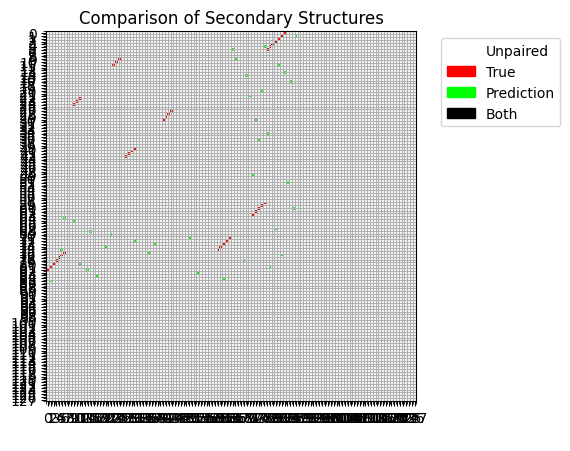

In [16]:
check(model, tt, 5)

## Single-Stage Blurry Training

In [17]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "secondary_distance_half"
)
N_MAX_EPOCHS = 500
model = deep.NN(
    model=MODEL_UNDER_TEST(SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-02T15:39:23.331903 > INFO Training the model with 1860 data points.
2024-06-02T15:39:23.334417 >     Using 232 data points for validation.
2024-06-02T15:39:23.335431 >     Beginning the training.
2024-06-02T15:39:24.117532 >   0 / 500 [                                                  ] Loss: 0.03426  Patience: 5
2024-06-02T15:39:24.707735 >   1 / 500 [                                                  ] Loss: 0.02502  Patience: 5
2024-06-02T15:39:25.253414 >   2 / 500 [                                                  ] Loss: 0.01986  Patience: 5
2024-06-02T15:39:25.841360 >   3 / 500 [                                                  ] Loss: 0.01586  Patience: 5
2024-06-02T15:39:26.337507 >   4 / 500 [                                                  ] Loss: 0.01404  Patience: 5
2024-06-02T15:39:26.923362 >   5 / 500 [                                                  ] Loss: 0.01320  Patience: 5
2024-06-02T15:39:27.484409 >   6 / 500 [                                          

In [19]:
V1_f1 = evaluate_model(model, tt)
V1_f1_mean = np.mean(evaluate_model(model, tt))
print(V1_f1)
print(V1_f1_mean)

[0.12903225421905518, 0.18390806019306183, 0.23255814611911774, 0.3488372266292572, 0.10256411135196686, 0.10000000149011612, 0.3076923191547394, 0.3103448450565338, 0.15000000596046448, 0.3448275625705719, 0.2857142686843872, 0.31578946113586426, 0.2545454800128937, 0.25, 0.2682926654815674, 0.056338030844926834, 0.23255816102027893, 0.21686746180057526, 0.37037035822868347, 0.1927710771560669, 0.3595505356788635, 0.03333333507180214, 0.06060606241226196, 0.2380952388048172, 0.09302325546741486, 0.18604649603366852, 0.21686746180057526, 0.1627907007932663, 0.18518517911434174, 0.26829269528388977, 0.07594936341047287, 0.16091953217983246, 0.0, 0.1149425283074379, 0.37777775526046753, 0.0, 0.37037035822868347, 0.4137931168079376, 0.2142857164144516, 0.10256409645080566, 0.02247190847992897, 0.10389610379934311, 0.3058823347091675, 0.29629629850387573, 0.40000003576278687, 0.3058823347091675, 0.15555556118488312, 0.3103448152542114, 0.0833333358168602, 0.22857142984867096, 0.04705882444

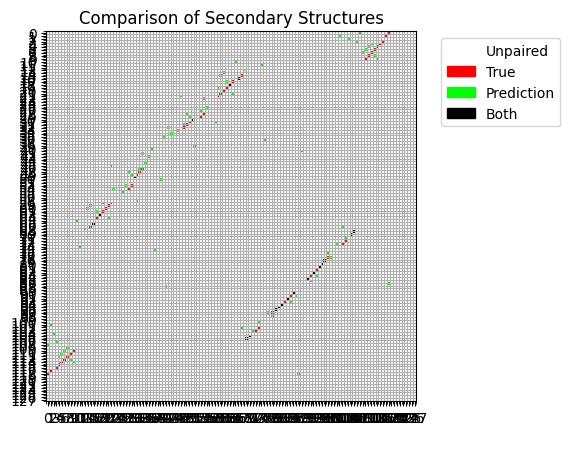

In [20]:
check(model, tt, 2)

## Single-Stage with more Blurry Input

In [21]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "secondary_distance_half_2"
)
N_MAX_EPOCHS = 500
model = deep.NN(
    model=MODEL_UNDER_TEST(SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-02T15:42:51.325416 > INFO Training the model with 1860 data points.
2024-06-02T15:42:51.327198 >     Using 232 data points for validation.
2024-06-02T15:42:51.327198 >     Beginning the training.
2024-06-02T15:42:52.144665 >   0 / 500 [                                                  ] Loss: 0.04361  Patience: 5
2024-06-02T15:42:52.665378 >   1 / 500 [                                                  ] Loss: 0.03278  Patience: 5
2024-06-02T15:42:53.193898 >   2 / 500 [                                                  ] Loss: 0.02728  Patience: 5
2024-06-02T15:42:53.673143 >   3 / 500 [                                                  ] Loss: 0.02244  Patience: 5
2024-06-02T15:42:54.198136 >   4 / 500 [                                                  ] Loss: 0.01990  Patience: 5
2024-06-02T15:42:54.759657 >   5 / 500 [                                                  ] Loss: 0.01859  Patience: 5
2024-06-02T15:42:55.306228 >   6 / 500 [                                          

In [22]:
V1_f1 = evaluate_model(model, tt)
V1_f1_mean = np.mean(evaluate_model(model, tt))
print(V1_f1)
print(V1_f1_mean)

[0.10344827175140381, 0.25287356972694397, 0.09411764144897461, 0.2988505959510803, 0.05128205567598343, 0.10169491916894913, 0.23076923191547394, 0.1428571343421936, 0.24390242993831635, 0.3294117748737335, 0.1785714328289032, 0.14035089313983917, 0.2857142686843872, 0.11363636702299118, 0.1627907156944275, 0.0, 0.240963876247406, 0.2068965584039688, 0.23076923191547394, 0.07228915393352509, 0.2222222238779068, 0.10000000149011612, 0.0, 0.1204819306731224, 0.09090909361839294, 0.09090909361839294, 0.2380952537059784, 0.0941176488995552, 0.111111119389534, 0.024390244856476784, 0.07499999552965164, 0.23529411852359772, 0.14814816415309906, 0.04597701504826546, 0.13636364042758942, 0.0624999962747097, 0.1785714328289032, 0.3488372266292572, 0.1190476194024086, 0.05263158306479454, 0.0, 0.07792207598686218, 0.18823528289794922, 0.0714285746216774, 0.18518517911434174, 0.18390804529190063, 0.13333334028720856, 0.13793101906776428, 0.1690140813589096, 0.0882352888584137, 0.0238095223903656

## Three-Stage Training

In [36]:
N_MAX_EPOCHS = 500
model = deep.NN(
    model=MODEL_UNDER_TEST(SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)

In [37]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "secondary_distance_half_2"
)
model.n_epochs = 20
model.train(t, v)

2024-06-02T15:53:21.945213 > INFO Training the model with 1860 data points.
2024-06-02T15:53:21.946793 >     Using 232 data points for validation.
2024-06-02T15:53:21.946793 >     Beginning the training.
2024-06-02T15:53:22.814153 >  0 / 20 [                                                  ] Loss: 0.03779  Patience: 5
2024-06-02T15:53:23.275011 >  1 / 20 [==                                                ] Loss: 0.02997  Patience: 5
2024-06-02T15:53:23.851039 >  2 / 20 [=====                                             ] Loss: 0.02452  Patience: 5
2024-06-02T15:53:24.344834 >  3 / 20 [=======                                           ] Loss: 0.02002  Patience: 5
2024-06-02T15:53:24.831018 >  4 / 20 [==========                                        ] Loss: 0.01792  Patience: 5
2024-06-02T15:53:25.326174 >  5 / 20 [============                                      ] Loss: 0.01687  Patience: 5
2024-06-02T15:53:25.795706 >  6 / 20 [===============                                   ] Loss

In [33]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "secondary_distance_half"
)
model.n_epochs = 50
model.train(t, v)

2024-06-02T15:52:30.862301 > INFO Training the model with 1860 data points.
2024-06-02T15:52:30.864351 >     Using 232 data points for validation.
2024-06-02T15:52:30.866386 >     Beginning the training.
2024-06-02T15:52:31.766560 >  0 / 50 [                                                  ] Loss: 0.03444  Patience: 5
2024-06-02T15:52:32.455636 >  1 / 50 [=                                                 ] Loss: 0.02357  Patience: 5
2024-06-02T15:52:32.993255 >  2 / 50 [==                                                ] Loss: 0.01803  Patience: 5
2024-06-02T15:52:33.474316 >  3 / 50 [===                                               ] Loss: 0.01489  Patience: 5
2024-06-02T15:52:33.975662 >  4 / 50 [====                                              ] Loss: 0.01350  Patience: 5
2024-06-02T15:52:34.518477 >  5 / 50 [=====                                             ] Loss: 0.01263  Patience: 5
2024-06-02T15:52:35.008584 >  6 / 50 [======                                            ] Loss

In [38]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "contact_half"
)
model.n_epochs = 20
model.train(t, v)

2024-06-02T15:53:41.936839 > INFO Training the model with 1860 data points.
2024-06-02T15:53:41.936839 >     Using 232 data points for validation.
2024-06-02T15:53:41.954209 >     Beginning the training.
2024-06-02T15:53:42.888907 >  0 / 20 [                                                  ] Loss: 0.00189  Patience: 5
2024-06-02T15:53:43.381100 >  1 / 20 [==                                                ] Loss: 0.00188  Patience: 5
2024-06-02T15:53:43.861128 >  2 / 20 [=====                                             ] Loss: 0.00192  Patience: 4
2024-06-02T15:53:44.349603 >  3 / 20 [=======                                           ] Loss: 0.00192  Patience: 3
2024-06-02T15:53:44.836083 >  4 / 20 [==========                                        ] Loss: 0.00192  Patience: 2
2024-06-02T15:53:45.315291 >  5 / 20 [============                                      ] Loss: 0.00192  Patience: 1



In [39]:
V1_f1 = evaluate_model(model, tt)
V1_f1_mean = np.mean(evaluate_model(model, tt))
print(V1_f1)
print(V1_f1_mean)

[0.21621622145175934, 0.042553193867206573, 0.0833333358168602, 0.043478261679410934, 0.17142856121063232, 0.1666666716337204, 0.06666667014360428, 0.162162184715271, 0.1463414579629898, 0.12765957415103912, 0.15789474546909332, 0.11764706671237946, 0.125, 0.0, 0.043478261679410934, 0.25531914830207825, 0.12765957415103912, 0.08510638773441315, 0.05128205195069313, 0.04545454680919647, 0.125, 0.0, 0.1304347962141037, 0.04878048971295357, 0.0, 0.0416666679084301, 0.08510638773441315, 0.08695652335882187, 0.1538461595773697, 0.04000000283122063, 0.0, 0.0416666679084301, 0.0, 0.08510638773441315, 0.11764705926179886, 0.0, 0.05882353335618973, 0.0, 0.125, 0.0, 0.0833333283662796, 0.08695652335882187, 0.08510638773441315, 0.0416666679084301, 0.054054055362939835, 0.21276594698429108, 0.08000000566244125, 0.11428571492433548, 0.0833333283662796, 0.09090908616781235, 0.042553193867206573, 0.0555555559694767, 0.20408165454864502, 0.07692307978868484, 0.25, 0.15094339847564697, 0.0, 0.039215687